## Exercises

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Exercise 1: Multiply Ws with 0

In [31]:
# set the weights and biases to zero
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.0 # 10 values x 3 priors x 200 neur.
b1 = torch.randn(n_hidden,                        generator=g) * 0.0# 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.0 # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size,                      generator=g) * 0.0 # 27 output biases

parameters = [C, W1, b1, W2, b2] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

11897 parameters


In [32]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 + b1          
    h = torch.tanh(hpreact)          
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    h.retain_grad()
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())
    
    break # run only the first batch

      0/ 200000: 3.2958


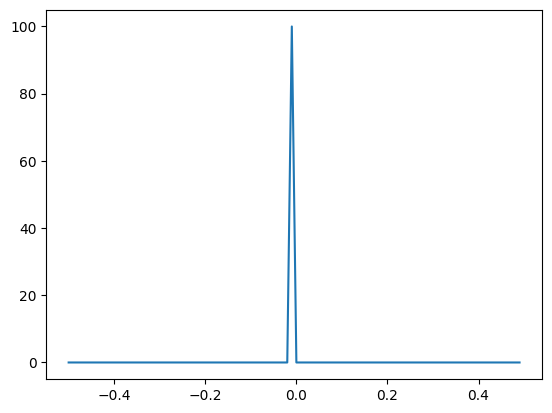

In [33]:
# analyze the actications of h
hy, hx = torch.histogram(h, density=True)
plt.plot(hx[:-1].detach(), hy.detach())

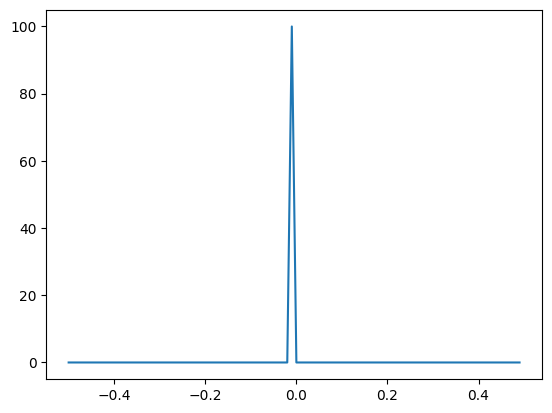

In [34]:
# analyze the gradients of h
hy, hx = torch.histogram(h.grad, density=True)
plt.plot(hx[:-1].detach(), hy.detach())

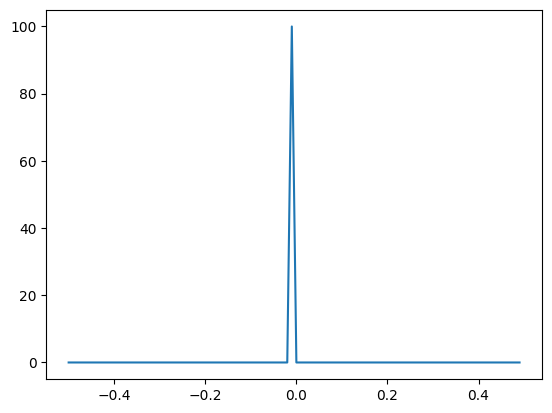

In [35]:
# analyze the pre-actications of h
hy, hx = torch.histogram(hpreact, density=True)
plt.plot(hx[:-1].detach(), hy.detach())

### Exercise 2: fold batchnorm gamma and beta into the weights of the preceeding linear layer

In [6]:
n_embd = 10    # dimensionality of the character embedding vectors
n_hidden = 200 # number of neurons in the hidden layer of the MLP

g  = torch.Generator().manual_seed(2147483647)                 # For reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g) # 27 letters x 10 values inp layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / (n_embd*block_size)**0.5 # 10 values x 3 priors x 200 neur.
# b1 = torch.randn(n_hidden,                        generator=g) * 0.01# 200 biases for the 200 neurons
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # 200 inputs x 27 output neurons
b2 = torch.randn(vocab_size,                      generator=g) * 0 # 27 output biases

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias] # Cluster all parameters into one structure
print(sum(p.nelement() for p in parameters), 'parameters') # total parameters (3481 before)

for p in parameters:
    p.requires_grad = True

12097 parameters


In [7]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # X,Y of this batch
    
    # Forward-Pass
    emb = C[Xb]                         
    embcat = emb.view(emb.shape[0], -1) 
    hpreact = embcat @ W1 # + b1

    hpreact_mean = hpreact.mean(dim=0, keepdim=True)
    hpreact_std = hpreact.std(dim=0, keepdim=True)
    hpreact = bngain * (hpreact - hpreact_mean) / hpreact_std + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * hpreact_mean
        bnstd_running = 0.999 * bnstd_running + 0.001 * hpreact_std

    h = torch.tanh(hpreact)             
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward-Pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if i < (max_steps / 2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Printing track stats every once in a while
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    
    # Adding current loss value to historic losses set (for later display)
    lossi.append(loss.log10().item())

/home/u229589/workspace/private/Andrej-Karpathy-Zero-To-Hero/.venv/lib/python3.10/site-packages/torch/autograd/__init__.py:200: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 103: integrity checks failed (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [21]:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)

    hpreact = embcat @ W1#  + b1
    hpreact = bngain * ((hpreact-bnmean_running) / bnstd_running) + bnbias
    
    h = torch.tanh(hpreact)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056840419769287


In [28]:
@torch.no_grad() # Decorator, disables gradient tracking (no "book-keeping" on torch's side)
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]    # That's a switch (never seen it like this!)
    
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # Concatenate into (N, block_size * n_embd)

    newW1 = (bngain * W1) / bnstd_running
    newBias = bngain * bnmean_running / bnstd_running + bnbias
    hpreact = embcat @ newW1 - newBias
    
    # hpreact = embcat @ W1#  + b1
    # hpreact = bngain * ((hpreact-bnmean_running) / bnstd_running) + bnbias
    
    h = torch.tanh(hpreact)    # (N, n_hidden)
    logits = h @ W2 + b2                # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.549636125564575
val 2.581920862197876
